# Sheet 2:  Generate Markov Random Field interactions consistent with matching curves

In [11]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.spatial import distance_matrix
from multiprocessing import Process, Manager, Pool
import copy
import importlib

import binary_hopfield as sim
import Ising_Model as im
import SED_utility as util

from pathlib import Path

map_folder = Path('C:/Users/djb/Dropbox/RESEARCH/APEX/SED/DATA/MAP_DATA')
results_folder = Path(Path.cwd()/'CALIB_RESULTS')
sed_data_folder = Path(Path.cwd()/'SED_DATA')
plots_folder = Path(Path.cwd()/'PLOTS')

In [12]:
#load up SED maps
importlib.reload(util)
files = os.listdir(sed_data_folder)
num_files = len(files)
print('num files = ', num_files)
files[:10]
df0 = util.get_SED_df(sed_data_folder,files[0])
L = df0['x'].values.shape[0]
XS = np.array([df0['x'].values,df0['y'].values]).T
dmat_SED = distance_matrix(XS,XS)

num files =  69


# Calibrate $\theta$ and calulate $\ln \mathcal{Z}$

In [7]:
bins = np.arange(0,500,10)
ds = 0.5*(bins[:-1]+bins[1:])

In [8]:
#Make neutral correlation function assuming states are {+1,-1}.
#For r values less than epsilon, interpolate betrween 1 and 2b-1
def make_C_neut(epsilon):
    def C_neut(r,b,c):
        a = b + c*np.log(np.where(r>epsilon,r/epsilon,1))
        m = 2*np.where(a>0.5,a,0.5)-1
        return np.where(r>epsilon,m,1-2*(1-b)*r/epsilon)
    return C_neut
    

## Neutral case

In [19]:
#*****************
#*****************
epsilon=10
C_neut=make_C_neut(epsilon)
#*****************
#*****************

df_bc = pd.read_csv('neutral_N5_b_c_epsilon_{}.csv'.format(epsilon))
b_vals = df_bc['b'].values
c_vals = df_bc['c'].values
df_bc.head()

,b,c
0,0.700,-0.074335
1,0.775,-0.068363
2,0.850,-0.055646
3,0.925,-0.029178
4,0.990,-0.005259


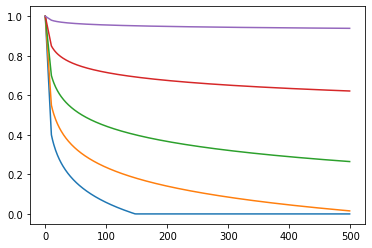

In [20]:
rs=np.arange(0,500,1)
for b,c in zip(b_vals,c_vals):
    plt.plot(rs,C_neut(rs,b,c))
plt.show()

In [21]:
importlib.reload(im)
cargs = {}
cargs['iterations'] = 200
cargs['learning_rate'] = 0.002
cargs['update_loops'] = 100
cargs['n_copies'] = 500

neut_cargs_list=[]
for b,c in zip(b_vals,c_vals):
    my_cargs = copy.deepcopy(cargs)
    C = C_neut(dmat_SED,b,c)
    #C[np.diag_indices(L)]=1
    my_cargs['C'] =  C
    neut_cargs_list.append(my_cargs)
    
n_proc = 5
if __name__ =='__main__':
    p = Pool(n_proc)
    neut_theta_results  = p.map(im.calib,neut_cargs_list) 

THETA_Neutral_param_0.700.csv  saved. 
THETA_Neutral_param_0.775.csv  saved. 
THETA_Neutral_param_0.850.csv  saved. 
THETA_Neutral_param_0.925.csv  saved. 
THETA_Neutral_param_0.990.csv  saved. 


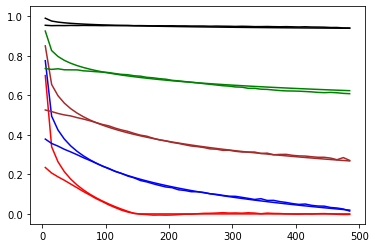

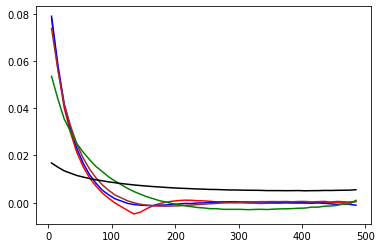

In [23]:
importlib.reload(util)
cols = ['red','blue','brown','green','black']
save = True
for b,c,(theta,C),col in zip(b_vals,c_vals,neut_theta_results,cols):
    
    if save:
        util.save_matrix(results_folder,'THETA_Neutral',b,theta)
    else:
        print('NOT SAVED b = ', b)
    
    Cs = util.CFunc(C,dmat_SED,bins)
    plt.plot(ds,Cs[1:],c=col)
    plt.plot(ds,C_neut(ds,b,c),c=col)
plt.ylim(-0.05,1.05)
plt.show()
    
for b,c,(theta,C),col in zip(b_vals,c_vals,neut_theta_results,cols):
    Cs = util.CFunc(theta,dmat_SED,bins)
    plt.plot(ds,Cs[1:],c=col)

plt.show()

In [24]:
importlib.reload(im)
zargs={}
zargs['n_copies']=500
zargs['anneal_steps']=200
zargs['intermediate_steps']=100

neut_zargs_list=[]
for b in b_vals:
    my_zargs = copy.deepcopy(zargs)
    theta = util.load_matrix(results_folder,'THETA_Neutral',b)
    my_zargs['theta'] =  theta
    neut_zargs_list.append(my_zargs)
    
n_proc = 5
if __name__ =='__main__':
    p = Pool(n_proc)
    neut_lnZ_results  = p.map(im.lnZ,neut_zargs_list) 

THETA_Neutral_param_0.700.csv  loaded. 
THETA_Neutral_param_0.775.csv  loaded. 
THETA_Neutral_param_0.850.csv  loaded. 
THETA_Neutral_param_0.925.csv  loaded. 
THETA_Neutral_param_0.990.csv  loaded. 


In [25]:
for b, lnZ in zip(b_vals,neut_lnZ_results):
    util.save_matrix(results_folder,'lnZ_Neutral',b,[lnZ])

lnZ_Neutral_param_0.700.csv  saved. 
lnZ_Neutral_param_0.775.csv  saved. 
lnZ_Neutral_param_0.850.csv  saved. 
lnZ_Neutral_param_0.925.csv  saved. 
lnZ_Neutral_param_0.990.csv  saved. 


## Interface case

In [13]:
df_mu = pd.read_csv('interface_mu_vals.csv'.format(epsilon))
mu_vals = df_mu['mu'].values
df_mu.head()

,mu
0,50
1,100
2,150
3,200
4,300


In [14]:
importlib.reload(im)
importlib.reload(util)

cargs = {}
cargs['iterations'] = 200
cargs['learning_rate'] = 0.004
cargs['update_loops'] = 100
cargs['n_copies'] = 500

potts_cargs_list=[]
for mu in mu_vals:
    my_cargs = copy.deepcopy(cargs)
    C = util.C_potts(dmat_SED,mu)
    #C[np.diag_indices(L)]=1
    my_cargs['C'] =  C
    potts_cargs_list.append(my_cargs)
    
n_proc = 5
if __name__ =='__main__':
    p = Pool(n_proc)
    potts_theta_results  = p.map(im.calib,potts_cargs_list) 

THETA_Potts_param_50.000.csv  saved. 
THETA_Potts_param_100.000.csv  saved. 
THETA_Potts_param_150.000.csv  saved. 
THETA_Potts_param_200.000.csv  saved. 
THETA_Potts_param_300.000.csv  saved. 


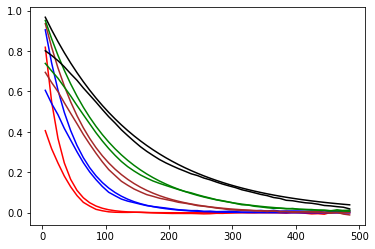

In [16]:
importlib.reload(util)
cols = ['red','blue','brown','green','black']
for mu,(theta,C),col in zip(mu_vals,potts_theta_results,cols):
    util.save_matrix(results_folder,'THETA_Potts',mu,theta)
    Cs = util.CFunc(C,dmat_SED,bins)
    plt.plot(ds,Cs[1:],c=col)
    plt.plot(ds,util.C_potts(ds,mu),c=col)

plt.show()

In [17]:
importlib.reload(im)
importlib.reload(util)
zargs={}
zargs['n_copies']=500
zargs['anneal_steps']=200
zargs['intermediate_steps']=100

potts_zargs_list=[]
for mu in mu_vals:
    my_zargs = copy.deepcopy(zargs)
    theta = util.load_matrix(results_folder,'THETA_Potts',mu)
    my_zargs['theta'] =  theta
    potts_zargs_list.append(my_zargs)
    
n_proc = 5
if __name__ =='__main__':
    p = Pool(n_proc)
    potts_lnZ_results  = p.map(im.lnZ,potts_zargs_list) 

THETA_Potts_param_50.000.csv  loaded. 
THETA_Potts_param_100.000.csv  loaded. 
THETA_Potts_param_150.000.csv  loaded. 
THETA_Potts_param_200.000.csv  loaded. 
THETA_Potts_param_300.000.csv  loaded. 


In [18]:
importlib.reload(util)
for mu, lnZ in zip(mu_vals,potts_lnZ_results):
    util.save_matrix(results_folder,'lnZ_Potts',mu,[lnZ])

lnZ_Potts_param_50.000.csv  saved. 
lnZ_Potts_param_100.000.csv  saved. 
lnZ_Potts_param_150.000.csv  saved. 
lnZ_Potts_param_200.000.csv  saved. 
lnZ_Potts_param_300.000.csv  saved. 
